### This Python code presents predicts Customer spending on streaming services through supervised learning models and identifies clustering patterns in customer behaviour through classification algorithms and unsupervised learning techniques

## Importing Libraries

In [3]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, roc_curve,
    silhouette_score, davies_bouldin_score
)


## DATA OVERVIEW

In [5]:
Streaming_df = pd.read_csv("Streaming.csv")
print(Streaming_df.head())

  Customer_ID   Age  Gender  Subscription_Length Region Payment_Method  \
0  CUST000001  56.0    Male                   54  South         PayPal   
1  CUST000002  69.0  Female                   21   East     Debit Card   
2  CUST000003  46.0  Female                   49   East         PayPal   
3  CUST000004  32.0    Male                   47   West     Debit Card   
4  CUST000005  60.0    Male                    6   East    Credit Card   

   Support_Tickets_Raised  Satisfaction_Score  Discount_Offered  \
0                       0                 9.0              6.42   
1                       1                 2.0             13.77   
2                       3                 8.0             19.91   
3                       3                 1.0             13.39   
4                       2                 NaN             13.18   

   Last_Activity  Monthly_Spend  Churned  
0            319          62.11        1  
1            166          37.27        1  
2            207       

In [6]:
Streaming_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer_ID             5000 non-null   object 
 1   Age                     4500 non-null   float64
 2   Gender                  5000 non-null   object 
 3   Subscription_Length     5000 non-null   int64  
 4   Region                  5000 non-null   object 
 5   Payment_Method          5000 non-null   object 
 6   Support_Tickets_Raised  5000 non-null   int64  
 7   Satisfaction_Score      4500 non-null   float64
 8   Discount_Offered        5000 non-null   float64
 9   Last_Activity           5000 non-null   int64  
 10  Monthly_Spend           5000 non-null   float64
 11  Churned                 5000 non-null   int64  
dtypes: float64(4), int64(4), object(4)
memory usage: 468.9+ KB


In [7]:
Streaming_df.isnull().sum()

Customer_ID                 0
Age                       500
Gender                      0
Subscription_Length         0
Region                      0
Payment_Method              0
Support_Tickets_Raised      0
Satisfaction_Score        500
Discount_Offered            0
Last_Activity               0
Monthly_Spend               0
Churned                     0
dtype: int64

## DATA CLEANING

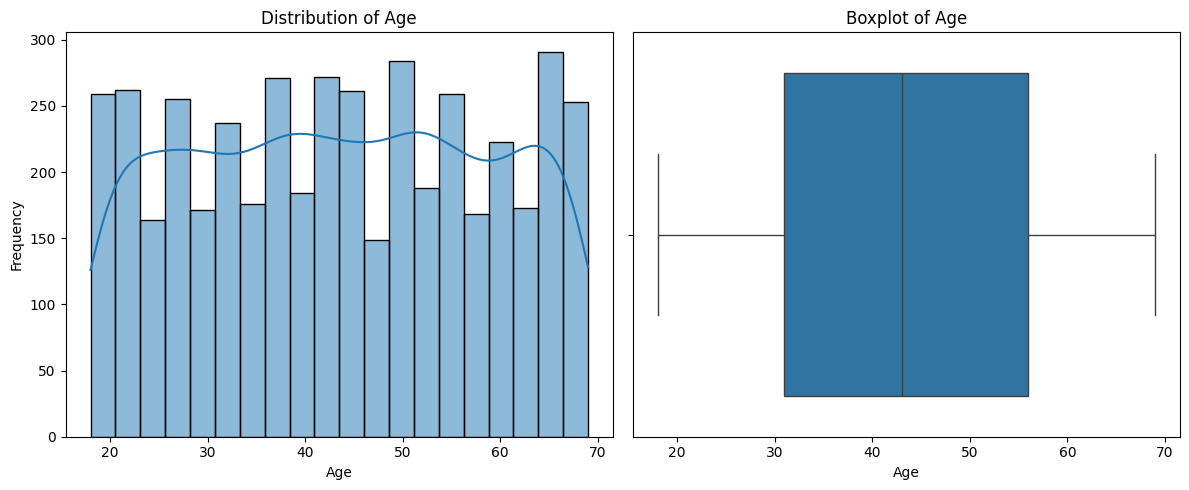

Summary statistics for Age:
count    4500.000000
mean       43.582222
std        14.969559
min        18.000000
25%        31.000000
50%        43.000000
75%        56.000000
max        69.000000
Name: Age, dtype: float64
Skewness for Age: -0.01



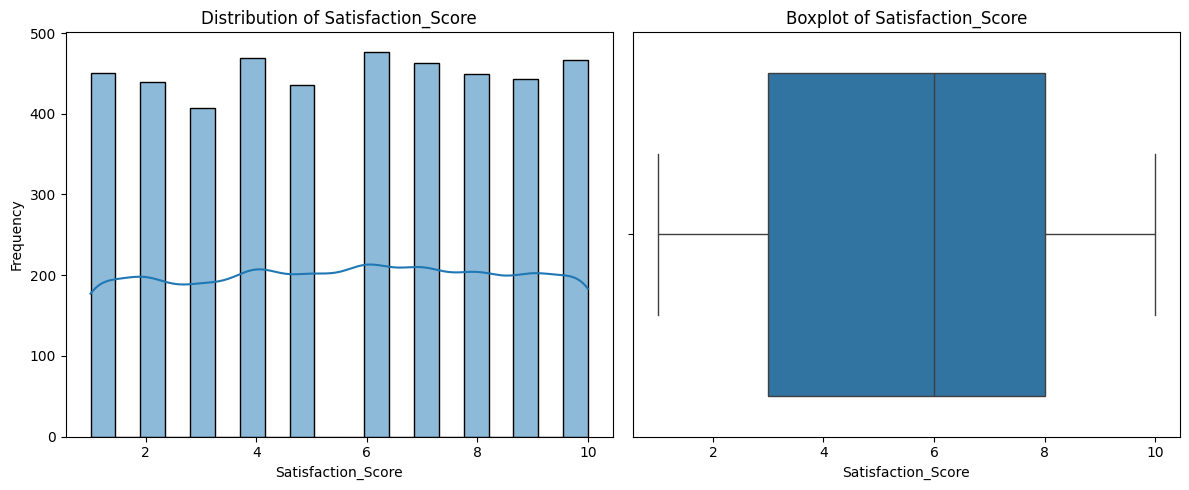

Summary statistics for Satisfaction_Score:
count    4500.00000
mean        5.54600
std         2.86929
min         1.00000
25%         3.00000
50%         6.00000
75%         8.00000
max        10.00000
Name: Satisfaction_Score, dtype: float64
Skewness for Satisfaction_Score: -0.03



In [8]:
# List of columns to check
columns_to_check = ['Age', 'Satisfaction_Score']

for col in columns_to_check:
    # Drop missing values for plotting
    data = Streaming_df[col].dropna()
    
    # Plot histogram with KDE and boxplot
    plt.figure(figsize=(12, 5))
    
    # Histogram with KDE
    plt.subplot(1, 2, 1)
    sns.histplot(data, kde=True, bins=20)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    
    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data)
    plt.title(f"Boxplot of {col}")
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics and skewness
    print(f"Summary statistics for {col}:")
    print(Streaming_df[col].describe())
    print(f"Skewness for {col}: {Streaming_df[col].skew():.2f}\n")


In [9]:
# Replace missing Age values with median
Streaming_df['Age'].fillna(Streaming_df['Age'].median(), inplace=True)

# Replace missing Satisfaction_Score values with median
Streaming_df['Satisfaction_Score'].fillna(Streaming_df['Satisfaction_Score'].median(), inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_9640\2946643324.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Streaming_df['Age'].fillna(Streaming_df['Age'].median(), inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_9640\2946643324.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves a

In [10]:
Streaming_df.isnull().sum()

Customer_ID               0
Age                       0
Gender                    0
Subscription_Length       0
Region                    0
Payment_Method            0
Support_Tickets_Raised    0
Satisfaction_Score        0
Discount_Offered          0
Last_Activity             0
Monthly_Spend             0
Churned                   0
dtype: int64

## Linear vs. Polynomial Regression

### Monthly Spend vs. Support Tickets Raised: Linear vs. Polynomial Regression

Linear Model:
  MAE = 7.6, MSE = 88.8, RMSE = 9.42, R² = 0.018

Polynomial Model (Degree=2):
  MAE = 7.61, MSE = 88.92, RMSE = 9.43, R² = 0.016


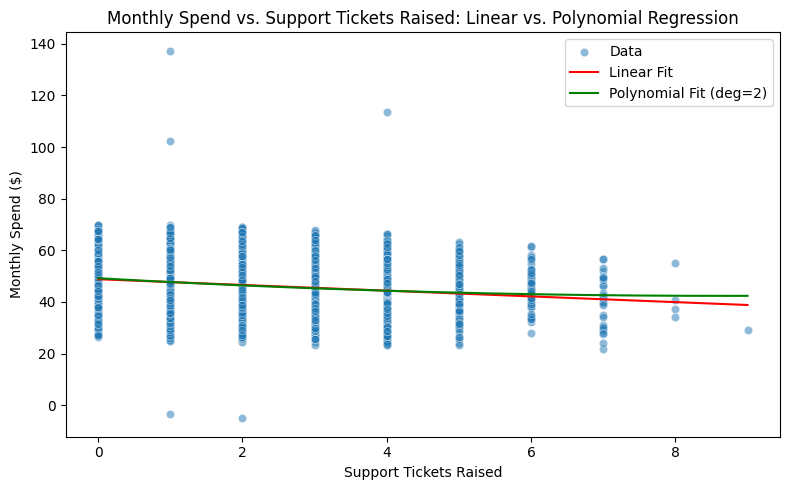

In [12]:
x = Streaming_df["Support_Tickets_Raised"].values.reshape(-1, 1)
y = Streaming_df["Monthly_Spend"].values

# Train/test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Linear Regression
linear_model = LinearRegression()
linear_model.fit(x_train_scaled, y_train)
y_pred_linear = linear_model.predict(x_test_scaled)

# Evaluate Linear Model
mae_linear = round(mean_absolute_error(y_test, y_pred_linear), 2)
mse_linear = round(mean_squared_error(y_test, y_pred_linear),2)
rmse_linear = round(np.sqrt(mse_linear),2)
r2_linear = round(r2_score(y_test, y_pred_linear),3)

# Polynomial Regression (degree=2)
poly = PolynomialFeatures(degree=2)
x_train_poly = poly.fit_transform(x_train_scaled)
x_test_poly = poly.transform(x_test_scaled)

poly_model = LinearRegression()
poly_model.fit(x_train_poly, y_train)
y_pred_poly = poly_model.predict(x_test_poly)

# Evaluate Polynomial Model
mae_poly = round(mean_absolute_error(y_test, y_pred_poly), 2)
mse_poly = round(mean_squared_error(y_test, y_pred_poly),2)
rmse_poly = round(np.sqrt(mse_poly),2)
r2_poly = round(r2_score(y_test, y_pred_poly),3)

# Print comparison
print("Linear Model:")
print(f"  MAE = {mae_linear}, MSE = {mse_linear}, RMSE = {rmse_linear}, R² = {r2_linear}")

print("\nPolynomial Model (Degree=2):")
print(f"  MAE = {mae_poly}, MSE = {mse_poly}, RMSE = {rmse_poly}, R² = {r2_poly}")

# Plot Both Fits
# range of values for plotting
x_fit = np.linspace(Streaming_df["Support_Tickets_Raised"].min(), Streaming_df["Support_Tickets_Raised"].max(), 200).reshape(-1, 1)
x_fit_scaled = scaler.transform(x_fit)
#  Linear fit predictions
y_fit_linear = linear_model.predict(x_fit_scaled)
#  Polynomial fit predictions
x_fit_poly = poly.transform(x_fit_scaled)
y_fit_poly = poly_model.predict(x_fit_poly)

# Scatter plot of actual data
plt.figure(figsize=(8, 5))
sns.scatterplot(x=Streaming_df["Support_Tickets_Raised"], y=Streaming_df["Monthly_Spend"], alpha=0.5, label="Data")

# Plot linear regression line
plt.plot(x_fit, y_fit_linear, color='red', label="Linear Fit")

# Plot polynomial regression curve
plt.plot(x_fit, y_fit_poly, color='green', label="Polynomial Fit (deg=2)")

plt.xlabel("Support Tickets Raised")
plt.ylabel("Monthly Spend ($)")
plt.title("Monthly Spend vs. Support Tickets Raised: Linear vs. Polynomial Regression")
plt.legend()
plt.tight_layout()
plt.savefig("Monthly_Spend_vs_Support Tickets Raised_Linear_vs_Polynomial_Regression.png")
plt.show()


### Monthly Spend vs. Age: Linear vs. Polynomial Regression

Linear Model:
  MAE = 7.64, MSE = 90.48, RMSE = 9.51, R² = -0.001

Polynomial Model (Degree=2):
  MAE = 7.64, MSE = 90.47, RMSE = 9.51, R² = -0.001


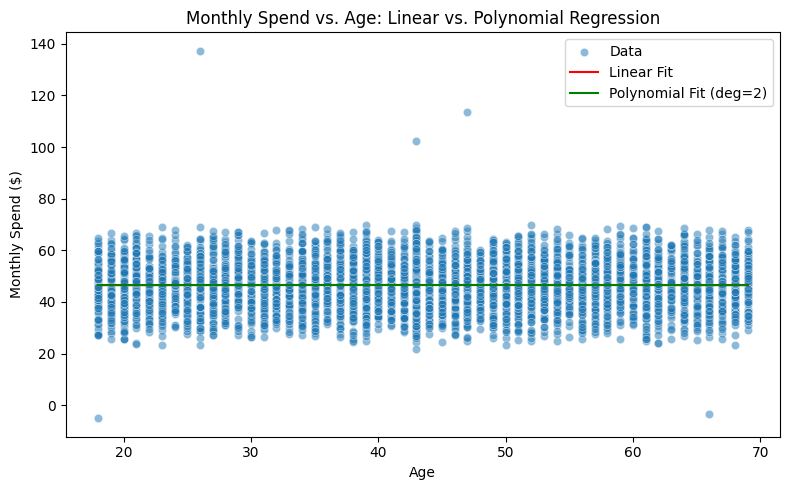

In [13]:
x = Streaming_df["Age"].values.reshape(-1, 1)
y = Streaming_df["Monthly_Spend"].values

# Train/test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Linear Regression
linear_model = LinearRegression()
linear_model.fit(x_train_scaled, y_train)
y_pred_linear = linear_model.predict(x_test_scaled)

# Evaluate Linear Model
mae_linear = round(mean_absolute_error(y_test, y_pred_linear), 2)
mse_linear = round(mean_squared_error(y_test, y_pred_linear),2)
rmse_linear = round(np.sqrt(mse_linear),2)
r2_linear = round(r2_score(y_test, y_pred_linear),3)

# Polynomial Regression (degree=2)
poly = PolynomialFeatures(degree=2)
x_train_poly = poly.fit_transform(x_train_scaled)
x_test_poly = poly.transform(x_test_scaled)

poly_model = LinearRegression()
poly_model.fit(x_train_poly, y_train)
y_pred_poly = poly_model.predict(x_test_poly)

# Evaluate Polynomial Model
mae_poly = round(mean_absolute_error(y_test, y_pred_poly), 2)
mse_poly = round(mean_squared_error(y_test, y_pred_poly),2)
rmse_poly = round(np.sqrt(mse_poly),2)
r2_poly = round(r2_score(y_test, y_pred_poly),3)

# Print comparison
print("Linear Model:")
print(f"  MAE = {mae_linear}, MSE = {mse_linear}, RMSE = {rmse_linear}, R² = {r2_linear}")

print("\nPolynomial Model (Degree=2):")
print(f"  MAE = {mae_poly}, MSE = {mse_poly}, RMSE = {rmse_poly}, R² = {r2_poly}")

# Plot Both Fits
#  range of values for plotting
x_fit = np.linspace(Streaming_df["Age"].min(), Streaming_df["Age"].max(), 200).reshape(-1, 1)
x_fit_scaled = scaler.transform(x_fit)
#  Linear fit predictions
y_fit_linear = linear_model.predict(x_fit_scaled)
#  Polynomial fit predictions
x_fit_poly = poly.transform(x_fit_scaled)
y_fit_poly = poly_model.predict(x_fit_poly)

# Scatter plot of actual data
plt.figure(figsize=(8, 5))
sns.scatterplot(x=Streaming_df["Age"], y=Streaming_df["Monthly_Spend"], alpha=0.5, label="Data")

# Plot linear regression line
plt.plot(x_fit, y_fit_linear, color='red', label="Linear Fit")

# Plot polynomial regression curve
plt.plot(x_fit, y_fit_poly, color='green', label="Polynomial Fit (deg=2)")

plt.xlabel("Age")
plt.ylabel("Monthly Spend ($)")
plt.title("Monthly Spend vs. Age: Linear vs. Polynomial Regression")
plt.legend()
plt.tight_layout()
plt.savefig("Monthly_Spend_vs_Age_Linear_vs_Polynomial_Regression.png")
plt.show()


### Monthly Spend vs. Subscription_Length(Months): Linear vs. Polynomial Regression

Linear Model:
  MAE = 6.64, MSE = 64.83, RMSE = 8.05, R² = 0.283

Polynomial Model (Degree=2):
  MAE = 6.65, MSE = 64.91, RMSE = 8.06, R² = 0.282


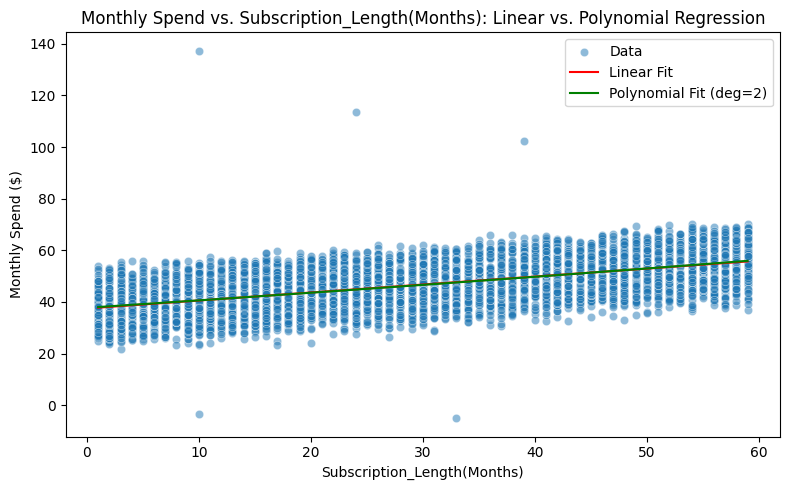

In [13]:
x = Streaming_df["Subscription_Length"].values.reshape(-1, 1)
y = Streaming_df["Monthly_Spend"].values

# Train/test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Linear Regression
linear_model = LinearRegression()
linear_model.fit(x_train_scaled, y_train)
y_pred_linear = linear_model.predict(x_test_scaled)

# Evaluate Linear Model
mae_linear = round(mean_absolute_error(y_test, y_pred_linear), 2)
mse_linear = round(mean_squared_error(y_test, y_pred_linear),2)
rmse_linear = round(np.sqrt(mse_linear),2)
r2_linear = round(r2_score(y_test, y_pred_linear),3)

# Polynomial Regression (degree=2)
poly = PolynomialFeatures(degree=2)
x_train_poly = poly.fit_transform(x_train_scaled)
x_test_poly = poly.transform(x_test_scaled)

poly_model = LinearRegression()
poly_model.fit(x_train_poly, y_train)
y_pred_poly = poly_model.predict(x_test_poly)

# Evaluate Polynomial Model
mae_poly = round(mean_absolute_error(y_test, y_pred_poly), 2)
mse_poly = round(mean_squared_error(y_test, y_pred_poly),2)
rmse_poly = round(np.sqrt(mse_poly),2)
r2_poly = round(r2_score(y_test, y_pred_poly),3)

# Print comparison
print("Linear Model:")
print(f"  MAE = {mae_linear}, MSE = {mse_linear}, RMSE = {rmse_linear}, R² = {r2_linear}")

print("\nPolynomial Model (Degree=2):")
print(f"  MAE = {mae_poly}, MSE = {mse_poly}, RMSE = {rmse_poly}, R² = {r2_poly}")

# Plot Both Fits
# range of values for plotting
x_fit = np.linspace(Streaming_df["Subscription_Length"].min(), Streaming_df["Subscription_Length"].max(), 200).reshape(-1, 1)
x_fit_scaled = scaler.transform(x_fit)
#  Linear fit predictions
y_fit_linear = linear_model.predict(x_fit_scaled)
#  Polynomial fit predictions
x_fit_poly = poly.transform(x_fit_scaled)
y_fit_poly = poly_model.predict(x_fit_poly)

# Scatter plot of actual data
plt.figure(figsize=(8, 5))
sns.scatterplot(x=Streaming_df["Subscription_Length"], y=Streaming_df["Monthly_Spend"], alpha=0.5, label="Data")

# Plot linear regression line
plt.plot(x_fit, y_fit_linear, color='red', label="Linear Fit")

# Plot polynomial regression curve
plt.plot(x_fit, y_fit_poly, color='green', label="Polynomial Fit (deg=2)")

plt.xlabel("Subscription_Length(Months)")
plt.ylabel("Monthly Spend ($)")
plt.title("Monthly Spend vs. Subscription_Length(Months): Linear vs. Polynomial Regression")
plt.legend()
plt.tight_layout()
plt.savefig("Monthly_Spend_vs_Subscription_Length(Months)_Linear_vs_Polynomial_Regression.png")
plt.show()


### Monthly Spend vs. Discount_Offered: Linear vs. Polynomial Regression

Linear Model:
  MAE = 7.42, MSE = 86.37, RMSE = 9.29, R² = 0.045

Polynomial Model (Degree=2):
  MAE = 7.42, MSE = 86.37, RMSE = 9.29, R² = 0.045


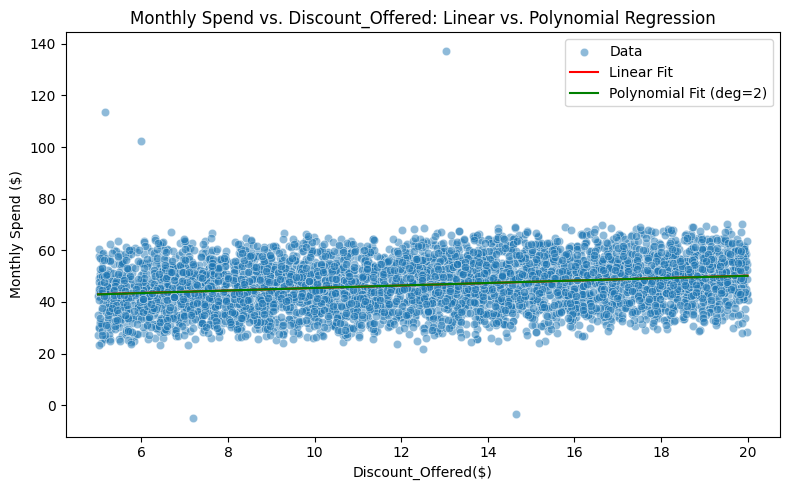

In [14]:
x = Streaming_df["Discount_Offered"].values.reshape(-1, 1)
y = Streaming_df["Monthly_Spend"].values

# Train/test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Linear Regression
linear_model = LinearRegression()
linear_model.fit(x_train_scaled, y_train)
y_pred_linear = linear_model.predict(x_test_scaled)

# Evaluate Linear Model
mae_linear = round(mean_absolute_error(y_test, y_pred_linear), 2)
mse_linear = round(mean_squared_error(y_test, y_pred_linear),2)
rmse_linear = round(np.sqrt(mse_linear),2)
r2_linear = round(r2_score(y_test, y_pred_linear),3)

# Polynomial Regression (degree=2)
poly = PolynomialFeatures(degree=2)
x_train_poly = poly.fit_transform(x_train_scaled)
x_test_poly = poly.transform(x_test_scaled)

poly_model = LinearRegression()
poly_model.fit(x_train_poly, y_train)
y_pred_poly = poly_model.predict(x_test_poly)

# Evaluate Polynomial Model
mae_poly = round(mean_absolute_error(y_test, y_pred_poly), 2)
mse_poly = round(mean_squared_error(y_test, y_pred_poly),2)
rmse_poly = round(np.sqrt(mse_poly),2)
r2_poly = round(r2_score(y_test, y_pred_poly),3)

# Print comparison
print("Linear Model:")
print(f"  MAE = {mae_linear}, MSE = {mse_linear}, RMSE = {rmse_linear}, R² = {r2_linear}")

print("\nPolynomial Model (Degree=2):")
print(f"  MAE = {mae_poly}, MSE = {mse_poly}, RMSE = {rmse_poly}, R² = {r2_poly}")

# Plot Both Fits
# range of values for plotting
x_fit = np.linspace(Streaming_df["Discount_Offered"].min(), Streaming_df["Discount_Offered"].max(), 200).reshape(-1, 1)
x_fit_scaled = scaler.transform(x_fit)
#  Linear fit predictions
y_fit_linear = linear_model.predict(x_fit_scaled)
#  Polynomial fit predictions
x_fit_poly = poly.transform(x_fit_scaled)
y_fit_poly = poly_model.predict(x_fit_poly)

# Scatter plot of actual data
plt.figure(figsize=(8, 5))
sns.scatterplot(x=Streaming_df["Discount_Offered"], y=Streaming_df["Monthly_Spend"], alpha=0.5, label="Data")

# Plot linear regression line
plt.plot(x_fit, y_fit_linear, color='red', label="Linear Fit")

# Plot polynomial regression curve
plt.plot(x_fit, y_fit_poly, color='green', label="Polynomial Fit (deg=2)")

plt.xlabel("Discount_Offered($)")
plt.ylabel("Monthly Spend ($)")
plt.title("Monthly Spend vs. Discount_Offered: Linear vs. Polynomial Regression")
plt.legend()
plt.tight_layout()
plt.savefig("Monthly_Spend_vs_Discount_Offered_Linear_vs_Polynomial_Regression.png")
plt.show()


### Monthly Spend vs. Satisfaction_Score: Linear vs. Polynomial Regression

Linear Model:
  MAE = 5.16, MSE = 42.08, RMSE = 6.49, R² = 0.534

Polynomial Model (Degree=2):
  MAE = 5.16, MSE = 42.08, RMSE = 6.49, R² = 0.535


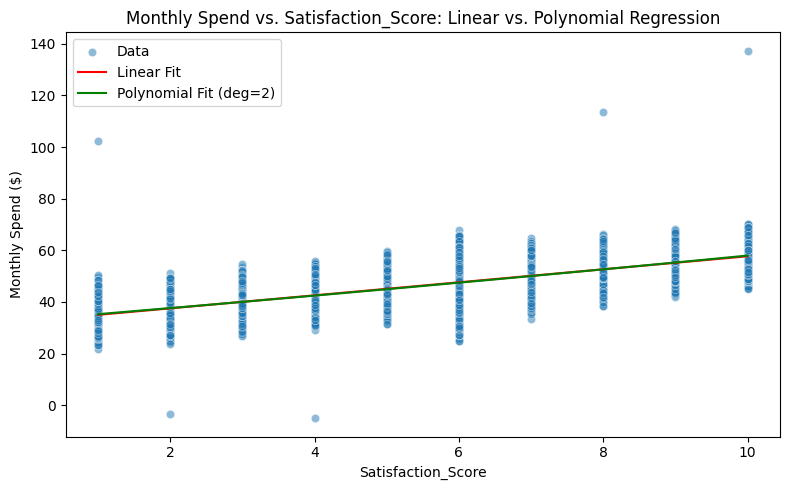

In [15]:
x = Streaming_df["Satisfaction_Score"].values.reshape(-1, 1)
y = Streaming_df["Monthly_Spend"].values

# Train/test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Linear Regression
linear_model = LinearRegression()
linear_model.fit(x_train_scaled, y_train)
y_pred_linear = linear_model.predict(x_test_scaled)

# Evaluate Linear Model
mae_linear = round(mean_absolute_error(y_test, y_pred_linear), 2)
mse_linear = round(mean_squared_error(y_test, y_pred_linear),2)
rmse_linear = round(np.sqrt(mse_linear),2)
r2_linear = round(r2_score(y_test, y_pred_linear),3)

# Polynomial Regression (degree=2)
poly = PolynomialFeatures(degree=2)
x_train_poly = poly.fit_transform(x_train_scaled)
x_test_poly = poly.transform(x_test_scaled)

poly_model = LinearRegression()
poly_model.fit(x_train_poly, y_train)
y_pred_poly = poly_model.predict(x_test_poly)

# Evaluate Polynomial Model
mae_poly = round(mean_absolute_error(y_test, y_pred_poly), 2)
mse_poly = round(mean_squared_error(y_test, y_pred_poly),2)
rmse_poly = round(np.sqrt(mse_poly),2)
r2_poly = round(r2_score(y_test, y_pred_poly),3)

# Print comparison
print("Linear Model:")
print(f"  MAE = {mae_linear}, MSE = {mse_linear}, RMSE = {rmse_linear}, R² = {r2_linear}")

print("\nPolynomial Model (Degree=2):")
print(f"  MAE = {mae_poly}, MSE = {mse_poly}, RMSE = {rmse_poly}, R² = {r2_poly}")

# Plot Both Fits
# range of values for plotting
x_fit = np.linspace(Streaming_df["Satisfaction_Score"].min(), Streaming_df["Satisfaction_Score"].max(), 200).reshape(-1, 1)
x_fit_scaled = scaler.transform(x_fit)
#  Linear fit predictions
y_fit_linear = linear_model.predict(x_fit_scaled)
#  Polynomial fit predictions
x_fit_poly = poly.transform(x_fit_scaled)
y_fit_poly = poly_model.predict(x_fit_poly)

# Scatter plot of actual data
plt.figure(figsize=(8, 5))
sns.scatterplot(x=Streaming_df["Satisfaction_Score"], y=Streaming_df["Monthly_Spend"], alpha=0.5, label="Data")

# Plot linear regression line
plt.plot(x_fit, y_fit_linear, color='red', label="Linear Fit")

# Plot polynomial regression curve
plt.plot(x_fit, y_fit_poly, color='green', label="Polynomial Fit (deg=2)")

plt.xlabel("Satisfaction_Score")
plt.ylabel("Monthly Spend ($)")
plt.title("Monthly Spend vs. Satisfaction_Score: Linear vs. Polynomial Regression")
plt.legend()
plt.tight_layout()
plt.savefig("Monthly_Spend_vs_Satisfaction_Score_vs_Polynomial_Regression.png")
plt.show()


### Monthly Spend vs. Last_Activity(Days): Linear vs. Polynomial Regression

Linear Model:
  MAE = 7.64, MSE = 90.49, RMSE = 9.51, R² = -0.001

Polynomial Model (Degree=2):
  MAE = 7.64, MSE = 90.48, RMSE = 9.51, R² = -0.001


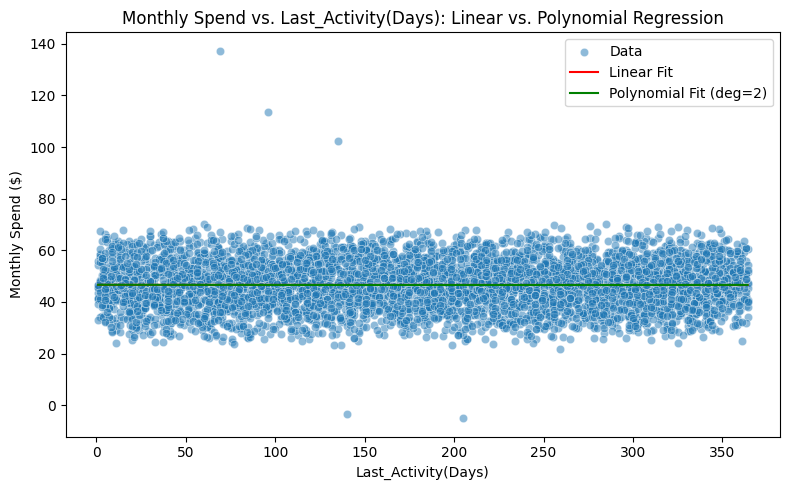

In [16]:
x = Streaming_df["Last_Activity"].values.reshape(-1, 1)
y = Streaming_df["Monthly_Spend"].values

# Train/test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Linear Regression
linear_model = LinearRegression()
linear_model.fit(x_train_scaled, y_train)
y_pred_linear = linear_model.predict(x_test_scaled)

# Evaluate Linear Model
mae_linear = round(mean_absolute_error(y_test, y_pred_linear), 2)
mse_linear = round(mean_squared_error(y_test, y_pred_linear),2)
rmse_linear = round(np.sqrt(mse_linear),2)
r2_linear = round(r2_score(y_test, y_pred_linear),3)

# Polynomial Regression (degree=2)
poly = PolynomialFeatures(degree=2)
x_train_poly = poly.fit_transform(x_train_scaled)
x_test_poly = poly.transform(x_test_scaled)

poly_model = LinearRegression()
poly_model.fit(x_train_poly, y_train)
y_pred_poly = poly_model.predict(x_test_poly)

# Evaluate Polynomial Model
mae_poly = round(mean_absolute_error(y_test, y_pred_poly), 2)
mse_poly = round(mean_squared_error(y_test, y_pred_poly),2)
rmse_poly = round(np.sqrt(mse_poly),2)
r2_poly = round(r2_score(y_test, y_pred_poly),3)

# Print comparison
print("Linear Model:")
print(f"  MAE = {mae_linear}, MSE = {mse_linear}, RMSE = {rmse_linear}, R² = {r2_linear}")

print("\nPolynomial Model (Degree=2):")
print(f"  MAE = {mae_poly}, MSE = {mse_poly}, RMSE = {rmse_poly}, R² = {r2_poly}")

# Plot Both Fits
# range of values for plotting
x_fit = np.linspace(Streaming_df["Last_Activity"].min(), Streaming_df["Last_Activity"].max(), 200).reshape(-1, 1)
x_fit_scaled = scaler.transform(x_fit)
#  Linear fit predictions
y_fit_linear = linear_model.predict(x_fit_scaled)
#  Polynomial fit predictions
x_fit_poly = poly.transform(x_fit_scaled)
y_fit_poly = poly_model.predict(x_fit_poly)

# Scatter plot of actual data
plt.figure(figsize=(8, 5))
sns.scatterplot(x=Streaming_df["Last_Activity"], y=Streaming_df["Monthly_Spend"], alpha=0.5, label="Data")

# Plot linear regression line
plt.plot(x_fit, y_fit_linear, color='red', label="Linear Fit")

# Plot polynomial regression curve
plt.plot(x_fit, y_fit_poly, color='green', label="Polynomial Fit (deg=2)")

plt.xlabel("Last_Activity(Days)")
plt.ylabel("Monthly Spend ($)")
plt.title("Monthly Spend vs. Last_Activity(Days): Linear vs. Polynomial Regression")
plt.legend()
plt.tight_layout()
plt.savefig("Monthly_Spend_vs_Last_Activity(Days)_vs_Polynomial_Regression.png")
plt.show()


### Multiple Linear Regression vs Random Forest Regression

Multiple Linear Regression Model Performance:
  MAE: 1.36
  MSE: 10.29
  RMSE: 3.21
  R²: 0.886 

Random Forest Regression Model Performance:
  MAE: 1.80
  MSE: 12.12
  RMSE: 3.48
  R²: 0.866


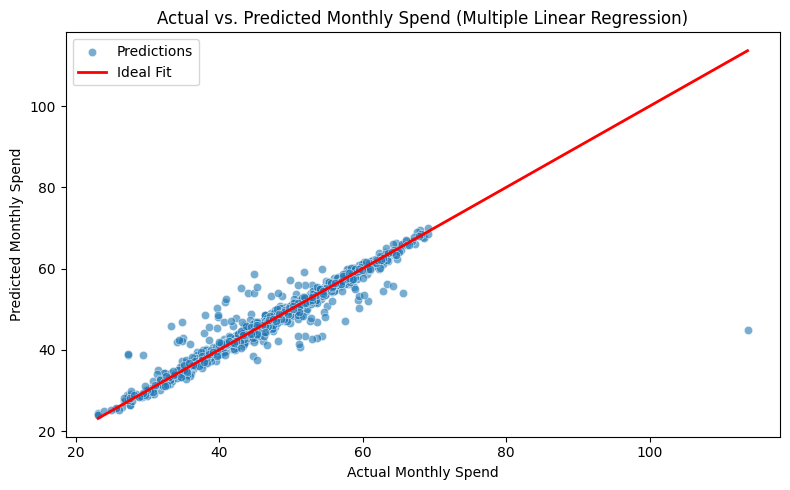

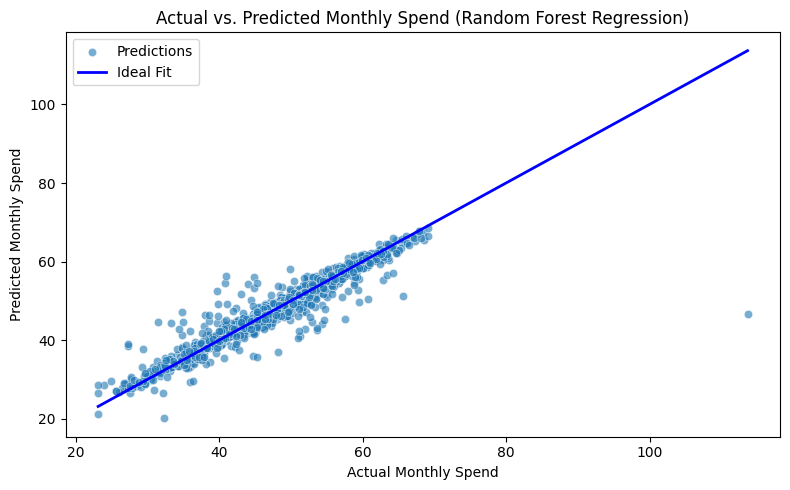

In [17]:
# Select the multiple features and target
features = ['Support_Tickets_Raised', 'Satisfaction_Score', 'Discount_Offered', 'Subscription_Length', 'Last_Activity', 'Age']
target = "Monthly_Spend"

# Separate into input features and target
X = Streaming_df[features]
y = Streaming_df[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Multiple Linear Regression
multi_model = LinearRegression()
multi_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = multi_model.predict(X_test_scaled)

# Model Evaluation- Multiple Linear Regression
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Multiple Linear Regression Model Performance:")
print(f"  MAE: {mae:.2f}")
print(f"  MSE: {mse:.2f}")
print(f"  RMSE: {rmse:.2f}")
print(f"  R²: {r2:.3f}",'\n')

# Random Forest Regression Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test_scaled)

# Model Evaluation- Random Forest Regression
mae_rf =  mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)


print("Random Forest Regression Model Performance:")
print(f"  MAE: {mae_rf:.2f}")
print(f"  MSE: {mse_rf:.2f}")
print(f"  RMSE: {rmse_rf:.2f}")
print(f"  R²: {r2_rf:.3f}")


# Plotting: Actual vs. Predicted - Multiple Linear Regression
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, label="Ideal Fit")
plt.xlabel("Actual Monthly Spend")
plt.ylabel("Predicted Monthly Spend")
plt.title("Actual vs. Predicted Monthly Spend (Multiple Linear Regression)")
plt.legend()
plt.tight_layout()
plt.savefig("Actual vs. Predicted Monthly Spend (Multiple Linear Regression).png")
plt.show()


# Plot Actual vs. Predicted for Random Forest Regression
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.6, label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='blue', lw=2, label="Ideal Fit")
plt.xlabel("Actual Monthly Spend")
plt.ylabel("Predicted Monthly Spend")
plt.title("Actual vs. Predicted Monthly Spend (Random Forest Regression)")
plt.legend()
plt.tight_layout()
plt.savefig("Actual vs. Predicted Monthly Spend (Random Forest Regression).png")
plt.show()

### Random Forest Regression with Numerical & Categorical Features

Random Forest Regression (with Numerical & Categorical Features) Performance:
  MAE: 1.83
  MSE: 12.22
  RMSE: 3.50
  R²: 0.865


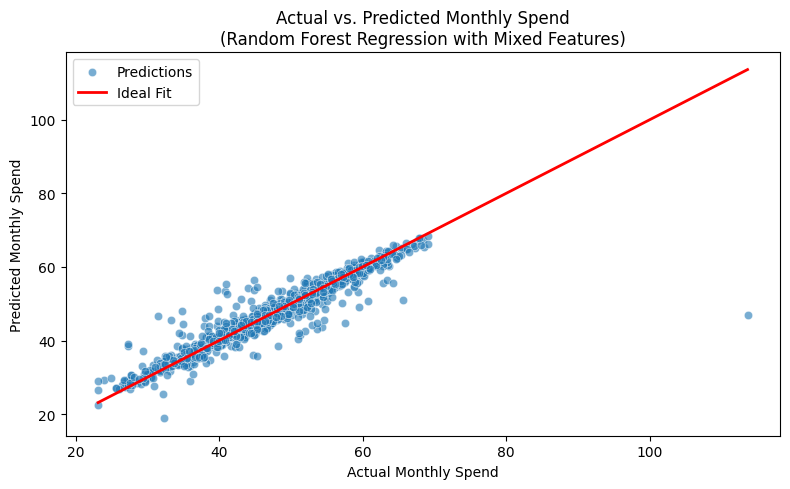

In [18]:
# Select numerical and categorical features
features = ["Support_Tickets_Raised", "Satisfaction_Score", "Discount_Offered", "Subscription_Length", "Last_Activity", "Age",
            "Gender", "Region", "Payment_Method"]
target = "Monthly_Spend"

# Drop rows with missing values for the selected columns
data = Streaming_df[features + [target]].copy()

# One-hot encode categorical variables
data_encoded = pd.get_dummies(data, columns=["Gender", "Region", "Payment_Method"], drop_first=True)

# Separate into input features (X) and target (y)
X = data_encoded.drop(columns=[target])
y = data_encoded[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training: Random Forest Regression
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Model Evaluation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Random Forest Regression (with Numerical & Categorical Features) Performance:")
print(f"  MAE: {mae:.2f}")
print(f"  MSE: {mse:.2f}")
print(f"  RMSE: {rmse:.2f}")
print(f"  R²: {r2:.3f}")

# Plotting: Actual vs. Predicted
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, label="Ideal Fit")
plt.xlabel("Actual Monthly Spend")
plt.ylabel("Predicted Monthly Spend")
plt.title("Actual vs. Predicted Monthly Spend\n(Random Forest Regression with Mixed Features)")
plt.legend()
plt.tight_layout()
plt.savefig("Actual vs. Predicted Monthly Spend(Random Forest Regression with Mixed Features).png")
plt.show()


### Artificial Neural Network (ANN) model 

C:\Users\user\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1932.6370 - mae: 42.1837 - val_loss: 78.7474 - val_mae: 7.1773
Epoch 2/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 131.3307 - mae: 8.8406 - val_loss: 40.4871 - val_mae: 5.1129
Epoch 3/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 78.1661 - mae: 7.0067 - val_loss: 20.4624 - val_mae: 3.5250
Epoch 4/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 63.1957 - mae: 6.1391 - val_loss: 11.3450 - val_mae: 2.4689
Epoch 5/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 57.2239 - mae: 5.6559 - val_loss: 9.2855 - val_mae: 2.1708
Epoch 6/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 53.9920 - mae: 5.7469 - val_loss: 8.9304 - val_mae: 2.1653
Epoch 7/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 47.0561 - mae: 5.2878 - val_loss: 8.1792 - val_mae: 1.9911
Epoch 8/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 46.8896 - mae: 5.1428 - val_loss: 6.5339 - val_mae: 1.5099
Epoch 9/200
113/113 ━━━━━━━━━━━━

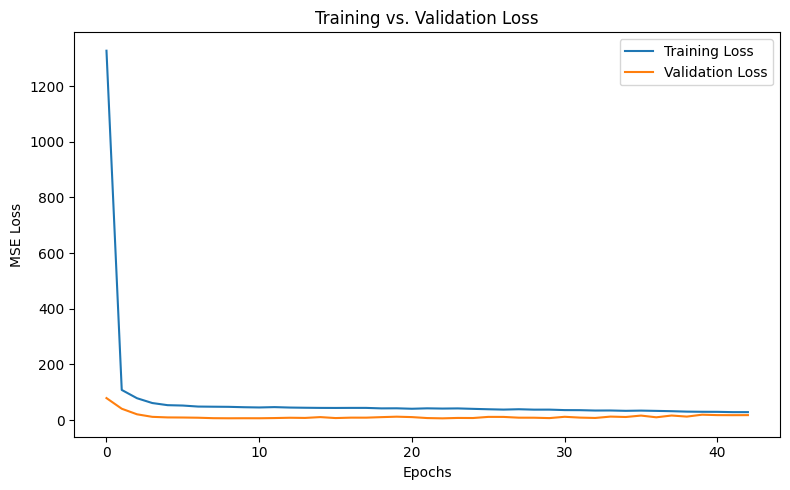

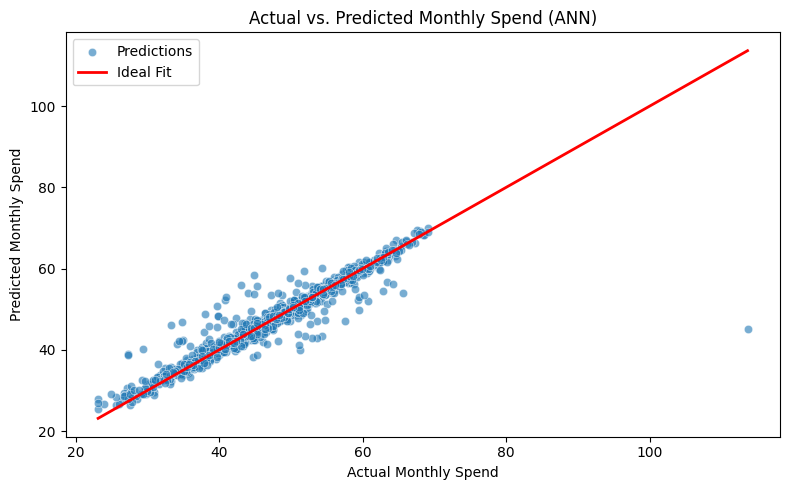

In [20]:
# Define the relevant features and target
features_all = ["Age", "Subscription_Length", "Support_Tickets_Raised", 
                "Satisfaction_Score", "Discount_Offered", "Last_Activity", 
                "Gender", "Region", "Payment_Method"]
target = "Monthly_Spend"

# Create a copy of the relevant data
data = Streaming_df[features_all + [target]].copy()

# One-hot encode categorical variables without dropping any rows
data_encoded = pd.get_dummies(data, columns=["Gender", "Region", "Payment_Method"], drop_first=True)

# Separate into input features and target
X = data_encoded.drop(columns=[target])
y = data_encoded[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# The ANN Model 
# Architecture choices: An ANN with an input layer matching the feature count, 
# two ReLU hidden layers (64 and 32 units) with 20% dropout, a third 16‑unit layer, 
# and a single linear output neuron.
model = Sequential()
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
# additional layer
model.add(Dense(16, activation='relu'))
model.add(Dense(1))  # Regression output

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the Model with Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = model.fit(X_train_scaled, y_train,
                    epochs=200,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[early_stopping],
                    verbose=1)

# Evaluate the ANN on Test Data
loss, mae = model.evaluate(X_test_scaled, y_test, verbose=0)
print("ANN Model Performance:")
print(f"  Test Loss (MSE): {loss:.2f}")
print(f"  Test MAE: {mae:.2f}")

# Make Predictions on Test Data
y_pred = model.predict(X_test_scaled)

# Compute R² score
from sklearn.metrics import r2_score
y_pred_ann = model.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
print(f"  Test R²: {r2:.2f}")

# Visualize Training History
history_df = pd.DataFrame(history.history)
plt.figure(figsize=(8, 5))
plt.plot(history_df["loss"], label="Training Loss")
plt.plot(history_df["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

# Plot Actual vs. Predicted Values
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred.flatten(), alpha=0.6, label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, label="Ideal Fit")
plt.xlabel("Actual Monthly Spend")
plt.ylabel("Predicted Monthly Spend")
plt.title("Actual vs. Predicted Monthly Spend (ANN)")
plt.legend()
plt.tight_layout()
plt.show()


### Logistic Regression Classification vs Random Forest Classifier

--- Logistic Regression Evaluation ---
Accuracy : 0.809
Precision: 0.793
Recall   : 0.785
F1 Score : 0.789
AUC-ROC  : 0.887

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.83      0.83       545
           1       0.79      0.78      0.79       455

    accuracy                           0.81      1000
   macro avg       0.81      0.81      0.81      1000
weighted avg       0.81      0.81      0.81      1000

-----------------------------

--- Random Forest Classifier Evaluation ---
Accuracy : 0.98
Precision: 1.0
Recall   : 0.956
F1 Score : 0.978
AUC-ROC  : 0.992

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       545
           1       1.00      0.96      0.98       455

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000

---------------

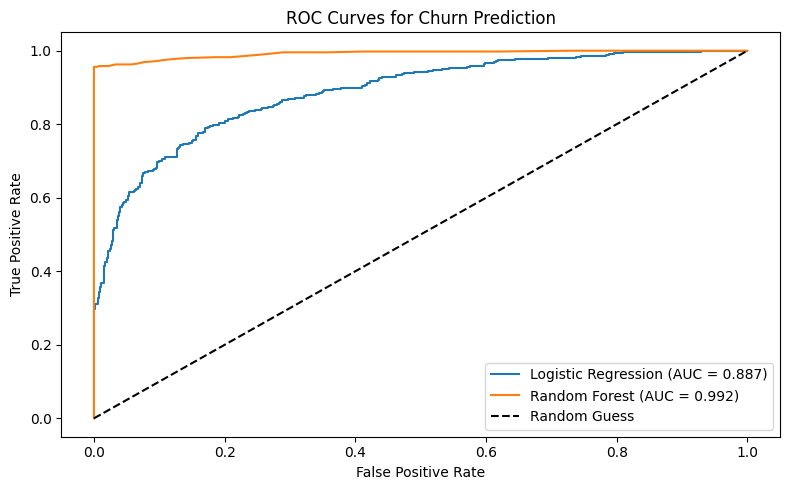

In [21]:
# Define the features and target for classification
features_cls = ["Age", "Subscription_Length", "Support_Tickets_Raised", 
                "Satisfaction_Score", "Discount_Offered", "Last_Activity", 
                "Gender", "Region", "Payment_Method"]
target_cls = "Churned"

# Create a copy of the data
data_cls = Streaming_df[features_cls + [target_cls]].copy()

# One-hot encode categorical variables dropping the first to avoid collinearity
data_cls_encoded = pd.get_dummies(data_cls, columns=["Gender", "Region", "Payment_Method"], drop_first=True)

# Separate into features and target
X_cls = data_cls_encoded.drop(columns=[target_cls])
y_cls = data_cls_encoded[target_cls]

# Train-Test Split
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)

# Feature Scaling
scaler_cls = StandardScaler()
X_train_cls_scaled = scaler_cls.fit_transform(X_train_cls)
X_test_cls_scaled = scaler_cls.transform(X_test_cls)

# Model Traininng
# a) Logistic Regression
logreg_model = LogisticRegression(max_iter=1000, random_state=42)
logreg_model.fit(X_train_cls_scaled, y_train_cls)
y_pred_logreg = logreg_model.predict(X_test_cls_scaled)
y_prob_logreg = logreg_model.predict_proba(X_test_cls_scaled)[:, 1]

# b) Random Forest Classifier
rf_model_cls = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_cls.fit(X_train_cls, y_train_cls) 
y_pred_rf = rf_model_cls.predict(X_test_cls)
y_prob_rf = rf_model_cls.predict_proba(X_test_cls)[:, 1]

# Model Evaluation
def print_classification_metrics(y_true, y_pred, y_prob, model_name):
    print(f"--- {model_name} Evaluation ---")
    print("Accuracy :", round(accuracy_score(y_true, y_pred), 3))
    print("Precision:", round(precision_score(y_true, y_pred), 3))
    print("Recall   :", round(recall_score(y_true, y_pred), 3))
    print("F1 Score :", round(f1_score(y_true, y_pred), 3))
    print("AUC-ROC  :", round(roc_auc_score(y_true, y_prob), 3))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))
    print("-----------------------------\n")

print_classification_metrics(y_test_cls, y_pred_logreg, y_prob_logreg, "Logistic Regression")
print_classification_metrics(y_test_cls, y_pred_rf, y_prob_rf, "Random Forest Classifier")

# Visualize the ROC Curves
fpr_logreg, tpr_logreg, _ = roc_curve(y_test_cls, y_prob_logreg)
fpr_rf, tpr_rf, _ = roc_curve(y_test_cls, y_prob_rf)

plt.figure(figsize=(8, 5))
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {roc_auc_score(y_test_cls, y_prob_logreg):.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test_cls, y_prob_rf):.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Churn Prediction")
plt.legend()
plt.tight_layout()
plt.savefig("ROC Curves for Churn Prediction.png")
plt.show()


## K-MEANS CLUSTERING 

### K-means Clusters based on Age and Monthly_Spend

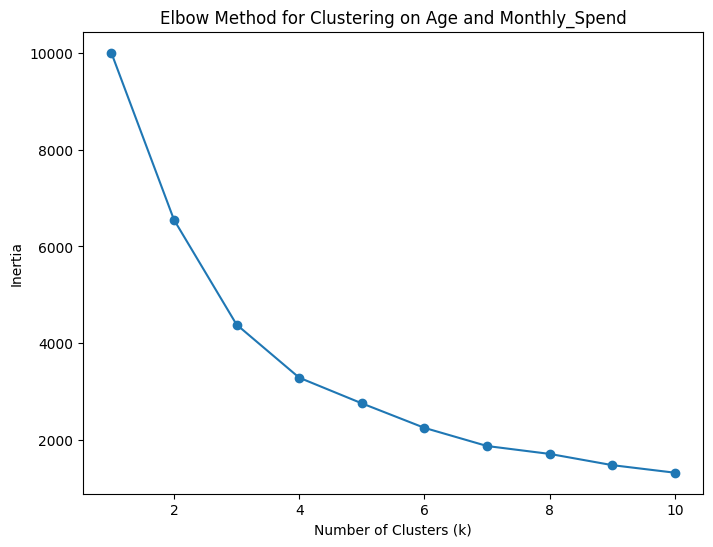

Evaluation Metrics for Different k:
k = 2: Silhouette Score = 0.326, Davies-Bouldin Score = 1.226
k = 3: Silhouette Score = 0.346, Davies-Bouldin Score = 0.941
k = 4: Silhouette Score = 0.332, Davies-Bouldin Score = 0.908
k = 5: Silhouette Score = 0.338, Davies-Bouldin Score = 0.890
k = 6: Silhouette Score = 0.354, Davies-Bouldin Score = 0.831
k = 7: Silhouette Score = 0.362, Davies-Bouldin Score = 0.795
k = 8: Silhouette Score = 0.350, Davies-Bouldin Score = 0.841
k = 9: Silhouette Score = 0.355, Davies-Bouldin Score = 0.810
k = 10: Silhouette Score = 0.351, Davies-Bouldin Score = 0.818

Final Clustering Evaluation:
Optimal number of clusters (k): 4
Final Inertia: 3288.3798786501575
Final Silhouette Score: 0.3323080419034392
Final Davies-Bouldin Score: 0.9081945883870177


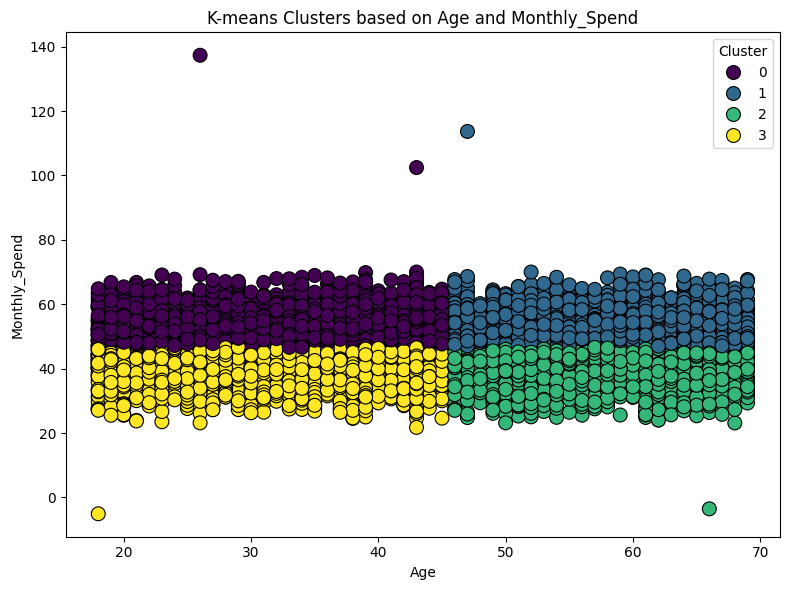

In [23]:
# Define the numeric features for clustering
numeric_features = ["Age", "Monthly_Spend"]
data_num = Streaming_df[numeric_features].copy()

# Scale the Data 
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_num)

# Evaluating different number of clusters
# Compute inertia for k values from 1 to 10 using the elbow method
inertia_list = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia_list.append(kmeans.inertia_)

plt.figure(figsize=(8,6))
plt.plot(k_range, inertia_list, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Clustering on Age and Monthly_Spend')
plt.show()

# print silhouette and Davies-Bouldin scoresfor k>=2
print("Evaluation Metrics for Different k:")
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data_scaled)
    sil = silhouette_score(data_scaled, labels)
    db = davies_bouldin_score(data_scaled, labels)
    print(f"k = {k}: Silhouette Score = {sil:.3f}, Davies-Bouldin Score = {db:.3f}")

# Fit the Final k-Means Model
optimal_k = 4
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans_final.fit_predict(data_scaled)

final_inertia = kmeans_final.inertia_
final_sil = silhouette_score(data_scaled, cluster_labels)
final_db = davies_bouldin_score(data_scaled, cluster_labels)

print("\nFinal Clustering Evaluation:")
print("Optimal number of clusters (k):", optimal_k)
print("Final Inertia:", final_inertia)
print("Final Silhouette Score:", final_sil)
print("Final Davies-Bouldin Score:", final_db)

# Visualize the Clusters
plt.figure(figsize=(8,6))
sns.scatterplot(x=data_num["Age"], y=data_num["Monthly_Spend"], 
                hue=cluster_labels, palette='viridis', s=100, edgecolor='k')
plt.xlabel("Age")
plt.ylabel("Monthly_Spend")
plt.title("K-means Clusters based on Age and Monthly_Spend")
plt.legend(title='Cluster')
plt.tight_layout()
plt.savefig("K-means Clusters based on Age and Monthly_Spend.png")
plt.show()


### K-means Clusters based on Last_Activity and Subscription_Length

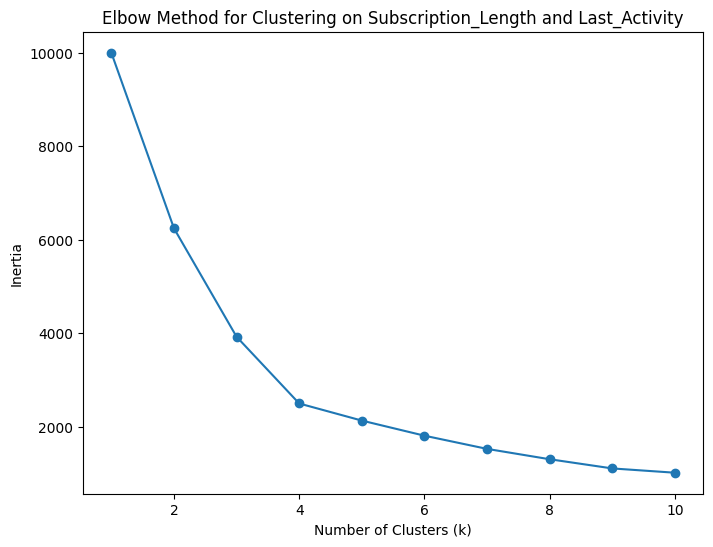

Evaluation Metrics for Different k:
k = 2: Silhouette Score = 0.354, Davies-Bouldin Score = 1.185
k = 3: Silhouette Score = 0.382, Davies-Bouldin Score = 0.858
k = 4: Silhouette Score = 0.406, Davies-Bouldin Score = 0.768
k = 5: Silhouette Score = 0.372, Davies-Bouldin Score = 0.897
k = 6: Silhouette Score = 0.346, Davies-Bouldin Score = 0.971
k = 7: Silhouette Score = 0.349, Davies-Bouldin Score = 0.925
k = 8: Silhouette Score = 0.357, Davies-Bouldin Score = 0.828
k = 9: Silhouette Score = 0.364, Davies-Bouldin Score = 0.791
k = 10: Silhouette Score = 0.364, Davies-Bouldin Score = 0.817

Final Clustering Evaluation:
Optimal number of clusters (k): 4
Final Inertia: 2500.8503764664215
Final Silhouette Score: 0.4056479255966497
Final Davies-Bouldin Score: 0.768141017416147


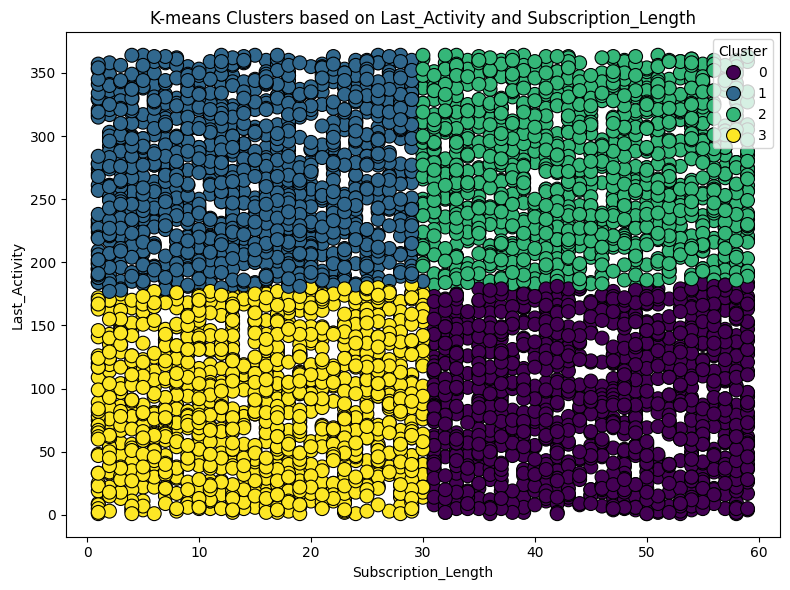

In [24]:
# Define the numeric features for clustering
numeric_features = ["Subscription_Length", "Last_Activity"]
data_num = Streaming_df[numeric_features].copy()

# Scale the Data 
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_num)

# Evaluating different number of clusters
# Compute inertia for k values from 1 to 10 using the elbow method
inertia_list = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia_list.append(kmeans.inertia_)

plt.figure(figsize=(8,6))
plt.plot(k_range, inertia_list, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Clustering on Subscription_Length and Last_Activity')
plt.show()

# print evaluation metrics for k>=2
print("Evaluation Metrics for Different k:")
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data_scaled)
    sil = silhouette_score(data_scaled, labels)
    db = davies_bouldin_score(data_scaled, labels)
    print(f"k = {k}: Silhouette Score = {sil:.3f}, Davies-Bouldin Score = {db:.3f}")

# Fit the Final k-Means Model
optimal_k = 4
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans_final.fit_predict(data_scaled)

final_inertia = kmeans_final.inertia_
final_sil = silhouette_score(data_scaled, cluster_labels)
final_db = davies_bouldin_score(data_scaled, cluster_labels)

print("\nFinal Clustering Evaluation:")
print("Optimal number of clusters (k):", optimal_k)
print("Final Inertia:", final_inertia)
print("Final Silhouette Score:", final_sil)
print("Final Davies-Bouldin Score:", final_db)

# Visualize the Clusters
plt.figure(figsize=(8,6))
sns.scatterplot(x=data_num["Subscription_Length"], y=data_num["Last_Activity"], 
                hue=cluster_labels, palette='viridis', s=100, edgecolor='k')
plt.xlabel("Subscription_Length")
plt.ylabel("Last_Activity")
plt.title("K-means Clusters based on Last_Activity and Subscription_Length")
plt.legend(title='Cluster')
plt.tight_layout()
plt.savefig("K-means Clusters based on Last_Activity and Subscription_Length.png")
plt.show()


### K-means Clusters based on Discount_Offered and Subscription_Length

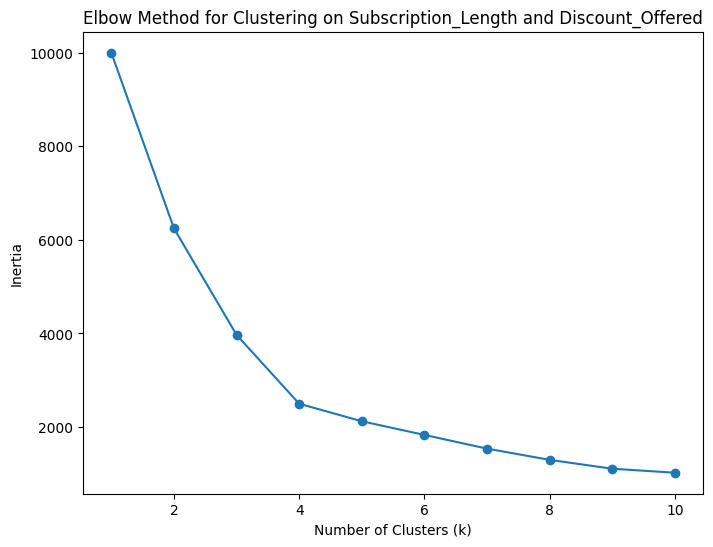

Evaluation Metrics for Different k:
k = 2: Silhouette Score = 0.354, Davies-Bouldin Score = 1.184
k = 3: Silhouette Score = 0.374, Davies-Bouldin Score = 0.872
k = 4: Silhouette Score = 0.408, Davies-Bouldin Score = 0.769
k = 5: Silhouette Score = 0.379, Davies-Bouldin Score = 0.894
k = 6: Silhouette Score = 0.357, Davies-Bouldin Score = 0.929
k = 7: Silhouette Score = 0.350, Davies-Bouldin Score = 0.918
k = 8: Silhouette Score = 0.366, Davies-Bouldin Score = 0.796
k = 9: Silhouette Score = 0.366, Davies-Bouldin Score = 0.777
k = 10: Silhouette Score = 0.358, Davies-Bouldin Score = 0.826

Final Clustering Evaluation:
Optimal number of clusters (k): 4
Final Inertia: 2496.2256035661285
Final Silhouette Score: 0.407746031452996
Final Davies-Bouldin Score: 0.7690458193093636


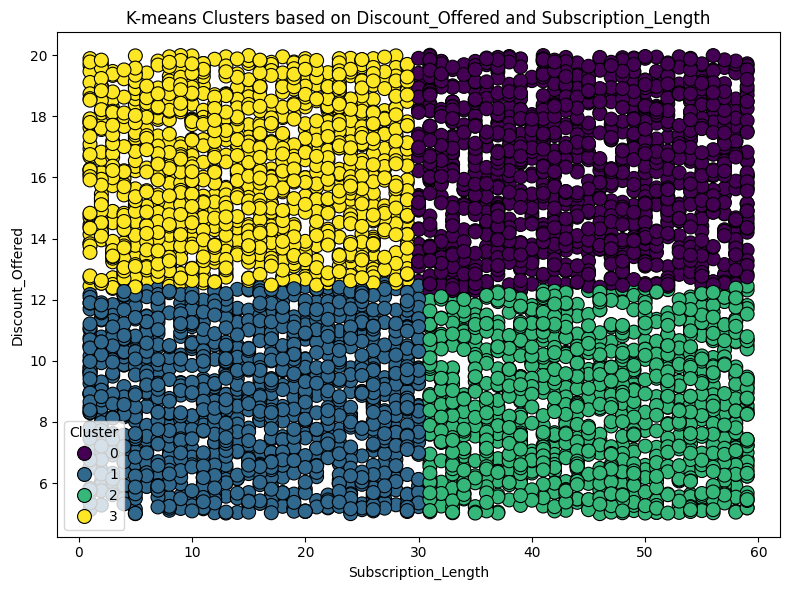

In [25]:
# Define the numeric features for clustering
numeric_features = ["Discount_Offered", "Subscription_Length"]
data_num = Streaming_df[numeric_features].copy()

# Scale the Data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_num)

# Evaluating different number of clusters
# Compute inertia for k values from 1 to 10 using the elbow method
inertia_list = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia_list.append(kmeans.inertia_)

plt.figure(figsize=(8,6))
plt.plot(k_range, inertia_list, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Clustering on Subscription_Length and Discount_Offered')
plt.show()

# print evaluation metrics for k>=2
print("Evaluation Metrics for Different k:")
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data_scaled)
    sil = silhouette_score(data_scaled, labels)
    db = davies_bouldin_score(data_scaled, labels)
    print(f"k = {k}: Silhouette Score = {sil:.3f}, Davies-Bouldin Score = {db:.3f}")

# Fit the Final k-Means Model
optimal_k = 4
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans_final.fit_predict(data_scaled)

final_inertia = kmeans_final.inertia_
final_sil = silhouette_score(data_scaled, cluster_labels)
final_db = davies_bouldin_score(data_scaled, cluster_labels)

print("\nFinal Clustering Evaluation:")
print("Optimal number of clusters (k):", optimal_k)
print("Final Inertia:", final_inertia)
print("Final Silhouette Score:", final_sil)
print("Final Davies-Bouldin Score:", final_db)

# Visualize the Clusters
plt.figure(figsize=(8,6))
sns.scatterplot(x=data_num["Subscription_Length"], y=data_num["Discount_Offered"], 
                hue=cluster_labels, palette='viridis', s=100, edgecolor='k')
plt.xlabel("Subscription_Length")
plt.ylabel("Discount_Offered")
plt.title("K-means Clusters based on Discount_Offered and Subscription_Length")
plt.legend(title='Cluster')
plt.tight_layout()
plt.savefig("K-means Clusters based on Discount_Offered and Subscription_Length.png")
plt.show()


## Hierarchical Clustering

### Hierarchical Clusters based on Age and Monthly Spend

Evaluation Metrics for Agglomerative Clustering for Different k:
k = 2: Silhouette Score = 0.284, Davies-Bouldin Score = 1.354
k = 3: Silhouette Score = 0.249, Davies-Bouldin Score = 1.228
k = 4: Silhouette Score = 0.269, Davies-Bouldin Score = 1.019
k = 5: Silhouette Score = 0.286, Davies-Bouldin Score = 0.986
k = 6: Silhouette Score = 0.296, Davies-Bouldin Score = 0.909
k = 7: Silhouette Score = 0.295, Davies-Bouldin Score = 0.871
k = 8: Silhouette Score = 0.301, Davies-Bouldin Score = 0.890
k = 9: Silhouette Score = 0.296, Davies-Bouldin Score = 0.897
k = 10: Silhouette Score = 0.308, Davies-Bouldin Score = 0.854

Final Clustering Evaluation:
Optimal number of clusters (k): 4
Final Silhouette Score: 0.2693134413173625
Final Davies-Bouldin Score: 1.0190321246373246


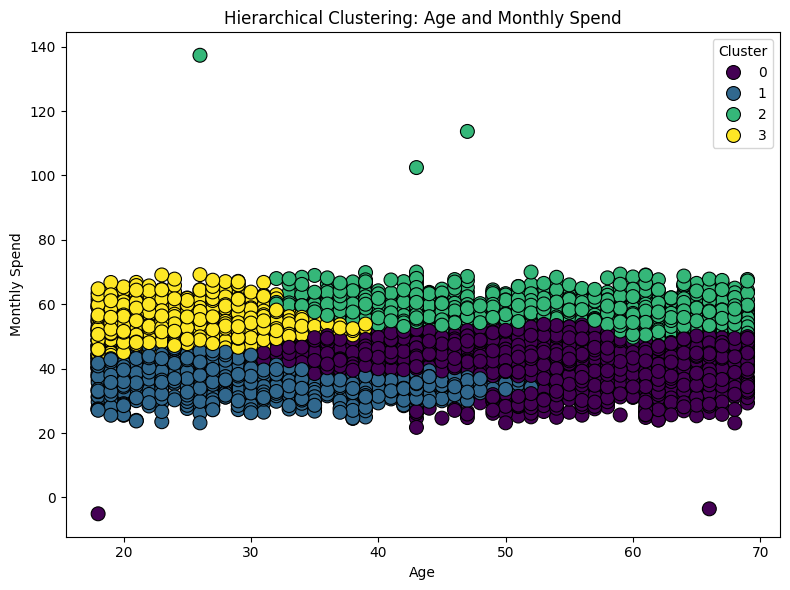

In [26]:
# Define the features: Age and Monthly_Spend
features = ["Age", "Monthly_Spend"]
data = Streaming_df[features].copy()

# Scale the Data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Evaluating different number of clusters
print("Evaluation Metrics for Agglomerative Clustering for Different k:")
for k in range(2, 11): 
    agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = agg.fit_predict(data_scaled)
    sil = silhouette_score(data_scaled, labels)
    db = davies_bouldin_score(data_scaled, labels)
    print(f"k = {k}: Silhouette Score = {sil:.3f}, Davies-Bouldin Score = {db:.3f}")

# Final Agglomerative Clustering ModeL
optimal_k = 4
agg_final = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
final_labels = agg_final.fit_predict(data_scaled)

final_sil = silhouette_score(data_scaled, final_labels)
final_db = davies_bouldin_score(data_scaled, final_labels)

print("\nFinal Clustering Evaluation:")
print("Optimal number of clusters (k):", optimal_k)
print("Final Silhouette Score:", final_sil)
print("Final Davies-Bouldin Score:", final_db)

# Visualize the Clusters
plt.figure(figsize=(8,6))
sns.scatterplot(x=data["Age"], y=data["Monthly_Spend"], 
                hue=final_labels, palette='viridis', s=100, edgecolor='k')
plt.xlabel("Age")
plt.ylabel("Monthly Spend")
plt.title("Hierarchical Clustering: Age and Monthly Spend")
plt.legend(title="Cluster")
plt.tight_layout()
plt.savefig("Hierarchical Clusters based on Age and Monthly Spend.png")
plt.show()


### Hierarchical Clusters based on Subscription Length vs Last Activity

Evaluation Metrics for Agglomerative Clustering (Different k):
k = 2: Silhouette Score = 0.330, Davies-Bouldin Score = 1.243
k = 3: Silhouette Score = 0.321, Davies-Bouldin Score = 0.924
k = 4: Silhouette Score = 0.335, Davies-Bouldin Score = 0.882
k = 5: Silhouette Score = 0.315, Davies-Bouldin Score = 0.964
k = 6: Silhouette Score = 0.299, Davies-Bouldin Score = 0.976
k = 7: Silhouette Score = 0.298, Davies-Bouldin Score = 0.902
k = 8: Silhouette Score = 0.314, Davies-Bouldin Score = 0.893
k = 9: Silhouette Score = 0.315, Davies-Bouldin Score = 0.866
k = 10: Silhouette Score = 0.304, Davies-Bouldin Score = 0.918

Final Clustering Evaluation (Hierarchical):
Optimal number of clusters (k): 4
Final Silhouette Score: 0.33524462883921957
Final Davies-Bouldin Score: 0.8821714615950087


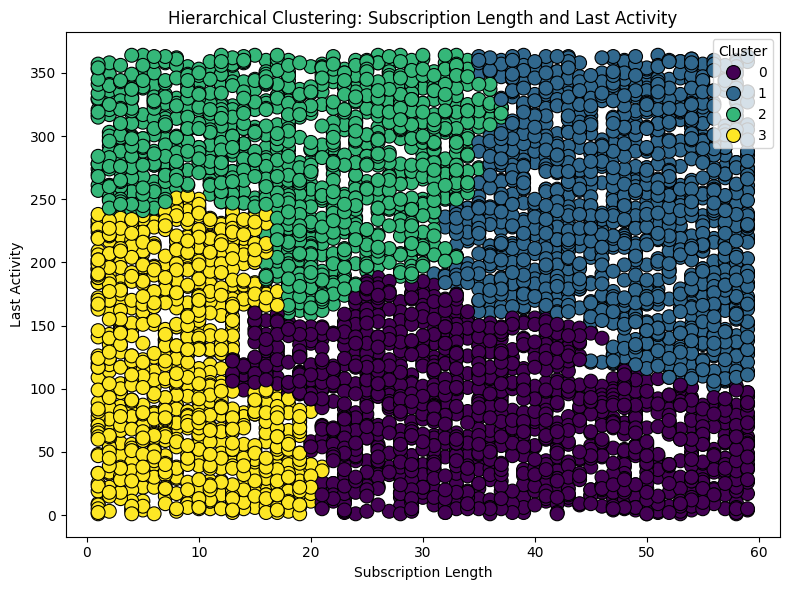

In [27]:
# Define the numeric features for clustering
numeric_features = ["Subscription_Length", "Last_Activity"]
data_num = Streaming_df[numeric_features].copy()

# Scale the Data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_num)

# Evaluating different number of clusters 
print("Evaluation Metrics for Agglomerative Clustering (Different k):")
for k in range(2, 11): 
    agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = agg.fit_predict(data_scaled)
    sil = silhouette_score(data_scaled, labels)
    db = davies_bouldin_score(data_scaled, labels)
    print(f"k = {k}: Silhouette Score = {sil:.3f}, Davies-Bouldin Score = {db:.3f}")

# Fit the Final Agglomerative Clustering Model
optimal_k = 4
agg_final = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
final_labels = agg_final.fit_predict(data_scaled)

final_sil = silhouette_score(data_scaled, final_labels)
final_db = davies_bouldin_score(data_scaled, final_labels)

print("\nFinal Clustering Evaluation (Hierarchical):")
print("Optimal number of clusters (k):", optimal_k)
print("Final Silhouette Score:", final_sil)
print("Final Davies-Bouldin Score:", final_db)

# Visualize the Clusters
plt.figure(figsize=(8,6))
sns.scatterplot(x=data_num["Subscription_Length"], y=data_num["Last_Activity"], 
                hue=final_labels, palette='viridis', s=100, edgecolor='k')
plt.xlabel("Subscription Length")
plt.ylabel("Last Activity")
plt.title("Hierarchical Clustering: Subscription Length and Last Activity")
plt.legend(title='Cluster')
plt.tight_layout()
plt.savefig("Hierarchical Clusters based on Subscription Length vs Last Activity.png")
plt.show()


### Hierarchical Clusters based on Discount_Offered vs Subscription Length

Evaluation Metrics for Agglomerative Clustering (Different k):
k = 2: Silhouette Score = 0.333, Davies-Bouldin Score = 1.207
k = 3: Silhouette Score = 0.357, Davies-Bouldin Score = 0.899
k = 4: Silhouette Score = 0.355, Davies-Bouldin Score = 0.806
k = 5: Silhouette Score = 0.333, Davies-Bouldin Score = 0.860
k = 6: Silhouette Score = 0.310, Davies-Bouldin Score = 0.883
k = 7: Silhouette Score = 0.296, Davies-Bouldin Score = 0.962
k = 8: Silhouette Score = 0.306, Davies-Bouldin Score = 0.960
k = 9: Silhouette Score = 0.309, Davies-Bouldin Score = 0.872
k = 10: Silhouette Score = 0.312, Davies-Bouldin Score = 0.897

Final Clustering Evaluation (Hierarchical):
Optimal number of clusters (k): 4
Final Silhouette Score: 0.3545084573122452
Final Davies-Bouldin Score: 0.8058630444806576


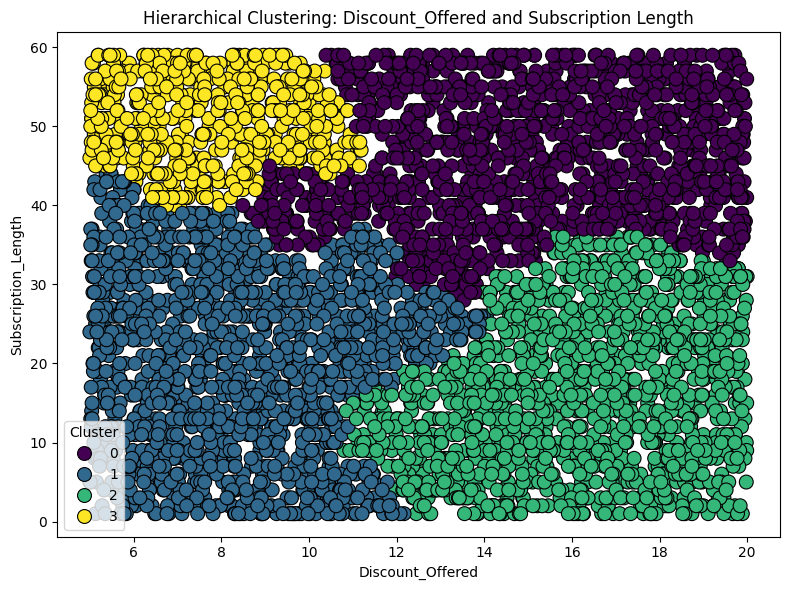

In [29]:
# Define the numeric features for clustering
numeric_features = ["Discount_Offered", "Subscription_Length"]
data_num = Streaming_df[numeric_features].copy()

# Scale the Data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_num)

# Evaluating different number of clusters 
print("Evaluation Metrics for Agglomerative Clustering (Different k):")
for k in range(2, 11): 
    agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = agg.fit_predict(data_scaled)
    sil = silhouette_score(data_scaled, labels)
    db = davies_bouldin_score(data_scaled, labels)
    print(f"k = {k}: Silhouette Score = {sil:.3f}, Davies-Bouldin Score = {db:.3f}")

# Fit the Final Agglomerative Clustering Model
optimal_k = 4
agg_final = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
final_labels = agg_final.fit_predict(data_scaled)

final_sil = silhouette_score(data_scaled, final_labels)
final_db = davies_bouldin_score(data_scaled, final_labels)

print("\nFinal Clustering Evaluation (Hierarchical):")
print("Optimal number of clusters (k):", optimal_k)
print("Final Silhouette Score:", final_sil)
print("Final Davies-Bouldin Score:", final_db)

# Visualize the Clusters
plt.figure(figsize=(8,6))
sns.scatterplot(x=data_num["Discount_Offered"], y=data_num["Subscription_Length"], 
                hue=final_labels, palette='viridis', s=100, edgecolor='k')
plt.xlabel("Discount_Offered")
plt.ylabel("Subscription_Length")
plt.title("Hierarchical Clustering: Discount_Offered and Subscription Length")
plt.legend(title='Cluster')
plt.tight_layout()
plt.savefig("Hierarchical Clusters based on Discount_Offered vs Subscription Length.png")
plt.show()
